In [1]:
import pathlib

import numpy as np
import pandas as pd;
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller
from tqdm import tqdm

from collections import OrderedDict, deque
from copy import deepcopy
import six

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="whitegrid")

from dag import DAG
from utils import *

In [2]:
df = pd.read_excel('./data/白酒板块股票收盘价.xlsx', header=1, index_col=0, skiprows=0).dropna()
tickers = df.columns
df.head()

,000568.SZ,600809.SH,600779.SH,603369.SH,600702.SH,002304.SZ,600197.SH,603589.SH,000860.SZ,600519.SH,000799.SZ,603198.SH,000858.SZ,600199.SH,002646.SZ,603919.SH,000596.SZ,600559.SH
Date,,,,,,,,,,,,,,,,,,
2016-03-10,22.12,15.94,9.92,27.39,16.60,66.30,12.00,29.78,18.78,228.06,13.73,19.08,25.14,7.43,16.18,15.75,33.00,49.82
2016-03-11,22.26,15.86,9.94,26.53,16.30,65.34,11.95,29.28,19.08,228.05,13.97,18.87,25.40,7.30,15.94,17.33,32.60,46.88
2016-03-14,22.54,16.25,10.22,27.38,17.09,64.27,12.19,30.04,19.30,224.57,14.18,19.44,25.45,7.51,17.53,19.06,32.58,48.17
2016-03-15,22.61,16.18,10.39,26.90,17.14,63.20,11.90,31.05,18.93,231.92,13.98,19.66,25.52,7.54,16.85,20.97,32.01,47.20
2016-03-16,22.53,15.99,10.35,27.10,17.12,62.90,11.74,30.19,18.92,228.61,13.70,19.29,25.28,7.42,16.81,23.07,32.19,46.89


[('000568.SZ', '603369.SH'), ('603369.SH', '002304.SZ'), ('603369.SH', '600519.SH'), ('603369.SH', '000858.SZ'), ('603369.SH', '000596.SZ'), ('002304.SZ', '600197.SH'), ('002304.SZ', '600519.SH'), ('002304.SZ', '000858.SZ'), ('600197.SH', '000799.SZ'), ('603589.SH', '600519.SH'), ('603589.SH', '000799.SZ'), ('603589.SH', '000858.SZ'), ('603589.SH', '000596.SZ'), ('600519.SH', '000596.SZ'), ('603198.SH', '600199.SH'), ('000858.SZ', '000596.SZ'), ('600199.SH', '603919.SH')]


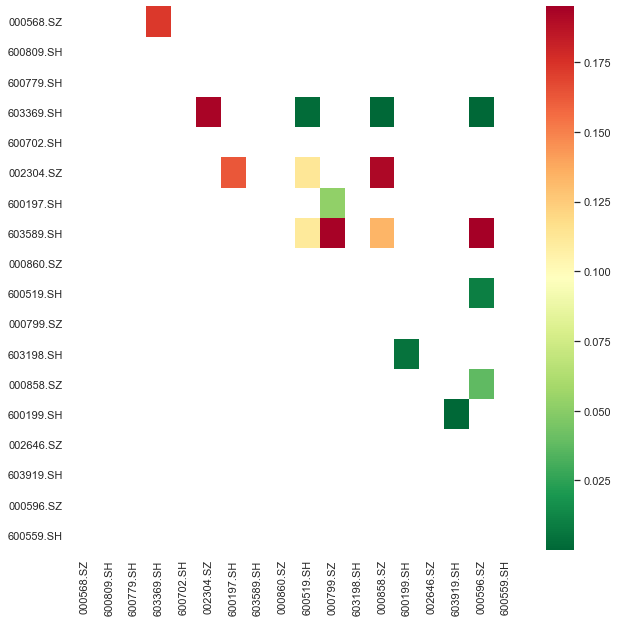

In [3]:
# Heatmap to show the p-values of the cointegration test between each pair of
# stocks. Only show the value in the upper-diagonal of the heatmap
scores, pvalues, pairs = find_cointegrated_pairs(df)
import seaborn
fig, ax = plt.subplots(figsize=(10,10))
seaborn.heatmap(pvalues, xticklabels=tickers, yticklabels=tickers, cmap='RdYlGn_r' 
                , mask = (pvalues >= 0.2)
                )
print(pairs)

In [9]:
groups = group_pairs(pairs)
orders = {k: [] for k in groups[0]}

start_point = -70
for i in range(10):
    dag = DAG()
    for node in groups[0]:
        dag.add_node(node)
    
    for pair in pairs:
        if not pair[0] in groups[0] or not pair[1] in groups[0]:
            continue
        
        data = df[[pair[0], pair[1]]].dropna()
        data = data.iloc[start_point-60:start_point]
        compute_zscore(data)

        if data['zscore'][-1] > 0:
            dag.add_edge(pair[1], pair[0])
        else:
            dag.add_edge(pair[0], pair[1])

    dag_list = dag.topological_sort()
    for i in range(len(groups[0])):
        orders[dag_list[i]].append(i + 1)
    
    start_point += 7

In [10]:
# display(orders)
result = pd.DataFrame(orders)
result

,000858.SZ,600197.SH,603589.SH,000568.SZ,002304.SZ,600519.SH,000596.SZ,603369.SH,000799.SZ
0,8,1,2,6,3,9,7,5,4
1,8,1,4,5,6,9,2,3,7
2,6,3,8,7,1,9,2,4,5
3,4,2,8,5,1,7,6,3,9
4,3,4,7,1,2,5,9,6,8
5,3,9,6,1,2,4,8,5,7
6,5,8,4,1,7,2,3,6,9
7,6,5,1,9,3,2,4,8,7
8,4,8,2,6,7,1,3,5,9
9,4,9,6,1,7,2,3,5,8


In [15]:
# Calculate the return from the ranking
data = df[groups[0]].iloc[-70:].copy(deep=True)
data['strategy'] = 0

# Sum return from each stock
for stock in groups[0]:
    ret = np.log(data[stock] / data[stock].shift(1)).fillna(0)
    for i in range(10):
        start = i * 7
        end = start + 7
        if (result[stock].iloc[i] < 4):
            data['strategy'].iloc[start:end] += ret * -0.25
        elif (result[stock].iloc[i] > 4):
            data['strategy'].iloc[start:end] += ret * 0.25

/usr/local/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [16]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
display(data)

,000858.SZ,600197.SH,603589.SH,000568.SZ,002304.SZ,600519.SH,000596.SZ,603369.SH,000799.SZ,strategy
Date,,,,,,,,,,
2021-03-09,242.50,18.18,54.31,187.21,160.83,1936.99,187.15,44.10,123.10,0.000000
2021-03-10,252.60,18.51,54.48,195.89,164.20,1970.01,188.51,44.57,130.25,0.019755
2021-03-11,265.04,18.70,55.55,207.02,166.89,2048.00,192.25,45.05,140.49,0.031652
2021-03-12,264.45,18.45,55.33,210.69,165.58,2026.00,191.99,44.74,140.20,0.005398
2021-03-15,251.01,18.04,54.30,196.00,157.87,1975.45,188.31,42.58,129.99,-0.032398
2021-03-16,262.41,18.39,55.40,200.99,162.90,2010.50,186.37,43.36,133.77,0.006076
2021-03-17,264.31,18.50,55.51,210.05,161.66,2030.36,190.34,43.70,135.70,0.022429
2021-03-18,270.39,18.68,56.14,219.00,167.15,2069.70,192.61,44.49,146.51,0.038562
2021-03-19,260.79,18.42,54.99,214.51,159.71,2010.00,187.35,44.06,143.09,-0.025967


In [17]:
get_returns(data['strategy'])

1.1065951803491263